In [1]:
import numpy as np
import pandas as pd
import json
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pickle

In [2]:
df_r = pd.DataFrame()
df_t = pd.DataFrame()
df_e = pd.DataFrame()

# read data from file
file = open('data/fulldata_1567845665/all.txt', 'r') 

for line in file:
    values = line.split(', ')
    if values[0] == 'R':
        df_r = df_r.append({'timestamp': values[1],'r_speed': values[2],'r_pos': values[3].rstrip()}, ignore_index=True)    
    if values[0] == 'T':
        df_t = df_t.append({'timestamp': values[1],'t_pos': values[2].rstrip()}, ignore_index=True)   
    if values[0] == 'E':
        data_dict = json.loads(', '.join(values[2:]))
        data_dict['time'] = values[1]
        df_e = df_e.append(data_dict, ignore_index=True)   

file.close()

# index
df_r['timestamp'] = pd.to_datetime(df_r['timestamp'],unit='s')
df_t['timestamp'] = pd.to_datetime(df_t['timestamp'],unit='s')
df_e['time'] = pd.to_datetime(df_e['time'],unit='s')
df_e = df_e.rename(columns={"time": "timestamp"})

df_r = df_r.set_index('timestamp')
df_t = df_t.set_index('timestamp')
df_e = df_e.set_index('timestamp')

# drop forceplot
df_e = df_e.drop(['forceplot'], axis=1)

# formatting
df_r['r_speed'] = df_r['r_speed'].astype(float)
df_r['r_speed'] = df_r['r_speed'] / 360

df_r['r_pos'] = df_r['r_pos'].astype(float)
df_r['r_pos'] = df_r['r_pos'] * 0.00246219 + 29.14

df_t['t_pos'] = df_t['t_pos'].astype(float)
df_t['t_pos'] = df_t['t_pos'] * 0.03 + 200

# df_e.head(20)

In [3]:
# merge all df

df = pd.concat([df_r, df_t, df_e], sort=False)
df = df.sort_index()
cols = ['calhr', 'calories', 'distance', 'heartrate', 'pace', 'power', 'spm', 'status', 'strokestate', 'r_pos', 'r_speed', 't_pos', 't_speed']
# df

In [4]:
# resample data

resample_modes = {'calhr': 'mean',
                  'calories': 'mean',
                  'distance': 'mean',
                  'heartrate': 'mean',
                  'pace': 'mean',
                  'power': 'mean',
                  'spm': 'mean',
                  'r_pos': 'mean',
                  'r_speed': 'mean',
                  't_pos': 'mean',
                  'status': 'first',
                  'strokestate': 'first'}

df = df.resample('20ms').agg(resample_modes)
# df

In [5]:
# add synthetic data

# t_speed
df['t_speed'] = df['t_pos'] - df['t_pos'].shift(periods=1)

# t_pos_ht1: sitz hinterer totpunkt 1
t_speed_last = df['t_speed'].shift(periods=1)
filter = (df['t_speed'] >= -5) & (t_speed_last < -5) & (df['t_pos'] <= 500)    
df.loc[filter, 't_ht1'] = 1

# t_pos_ht2: sitz hinterer totpunkt 2
t_speed_last = df['t_speed'].shift(periods=1)
filter = (df['t_speed'] >= 5) & (t_speed_last < 5) & (df['t_pos'] <= 500)    
df.loc[filter, 't_ht2'] = 1

# t_pos_vt: sitz vorderer totpunkt
t_speed_last = df['t_speed'].shift(periods=1)
filter = (df['t_speed'] < 0) & (t_speed_last >= 0) & (df['t_pos'] >= 500)    
df.loc[filter, 't_vt'] = 1

# stroke_start
sstate_last = df['strokestate'].shift(periods=1)
filter = (df['strokestate'] == 3) & (sstate_last == 2)  
df.loc[filter, 'stroke_start'] = 1

# r_ht: kette hinterer totpunkt
rspeed_last = df['r_speed'].shift(periods=1)
filter = (df['r_speed'] < 0) & (rspeed_last >= 0)  
df.loc[filter, 'r_ht'] = 1

# r_vt: kette vorderer totpunkt
rspeed_last = df['r_speed'].shift(periods=1)
filter = (df['r_speed'] > 0) & (rspeed_last <= 0)  
df.loc[filter, 'r_vt'] = 1

# df

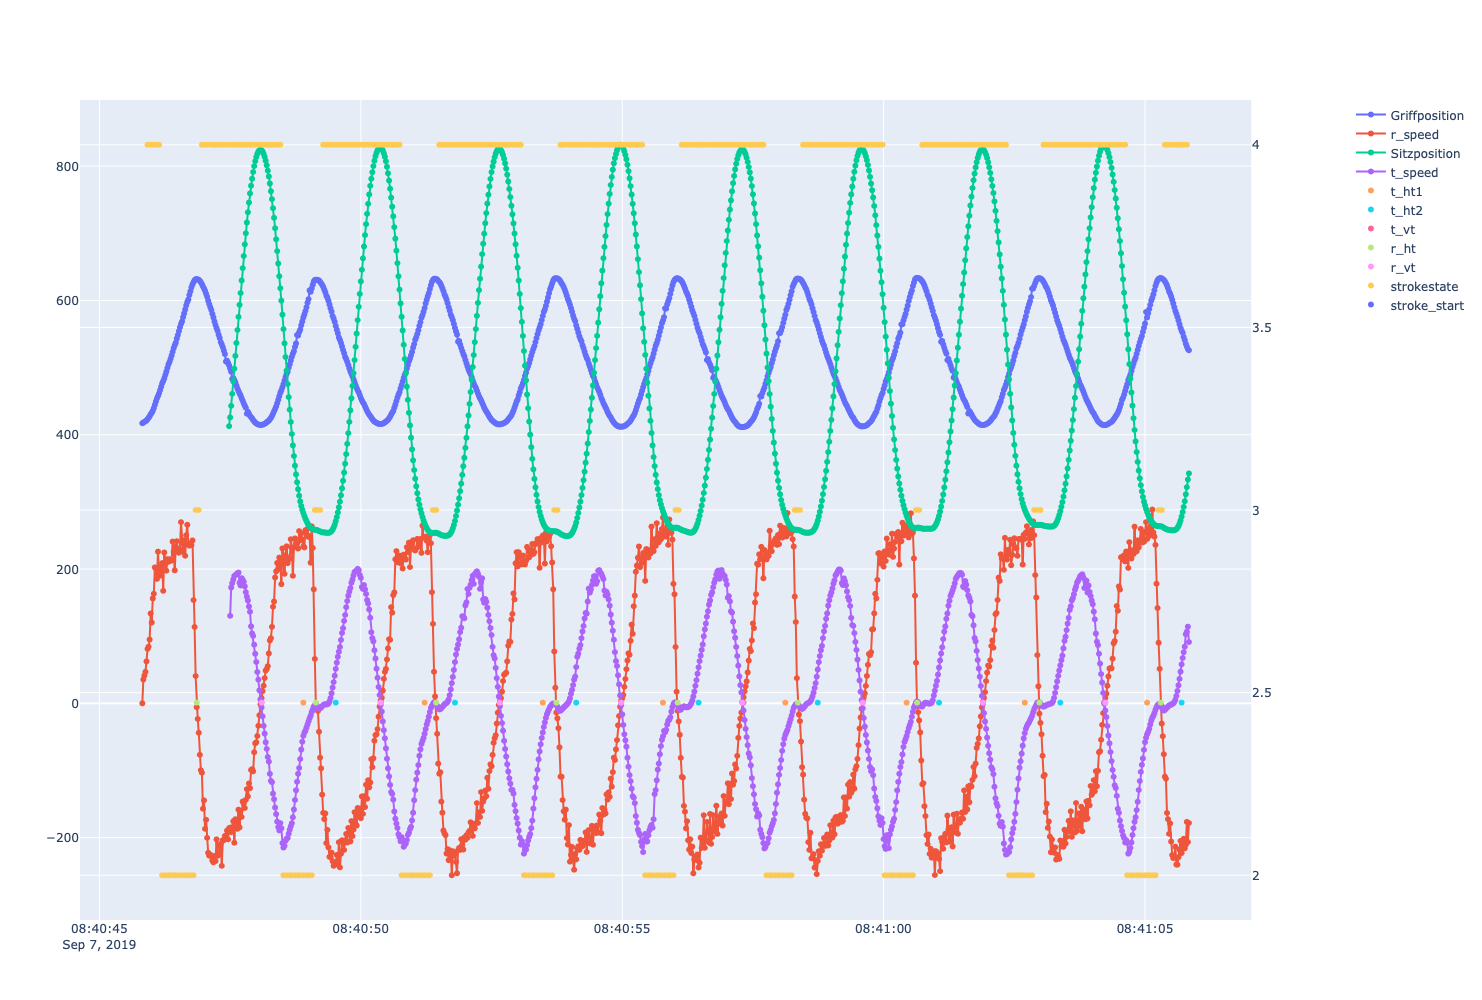

In [34]:
# plot data

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.update_layout(
    autosize=False,
    width=1500,
    height=1000
)

dfp = df#[:1000]

# sensor data
fig.add_trace(go.Scatter(x=dfp.index, y=dfp['r_pos']*15,
                    mode='lines+markers',
                    name='Griffposition'),
            secondary_y=False)
fig.add_trace(go.Scatter(x=dfp.index, y=dfp['r_speed'],
                    mode='lines+markers',
                    name='r_speed'),
            secondary_y=False)
fig.add_trace(go.Scatter(x=dfp.index, y=dfp['t_pos'],
                    mode='lines+markers',
                    name='Sitzposition'),
            secondary_y=False)
fig.add_trace(go.Scatter(x=dfp.index, y=dfp['t_speed']*10,
                    mode='lines+markers',
                    name='t_speed'),
            secondary_y=False)

# sythetic data
fig.add_trace(go.Scatter(x=dfp.index, y=dfp['t_ht1'],
                    mode='markers',
                    name='t_ht1'),
            secondary_y=False)
fig.add_trace(go.Scatter(x=dfp.index, y=dfp['t_ht2'],
                    mode='markers',
                    name='t_ht2'),
            secondary_y=False)
fig.add_trace(go.Scatter(x=dfp.index, y=dfp['t_vt'],
                    mode='markers',
                    name='t_vt'),
            secondary_y=False)
fig.add_trace(go.Scatter(x=dfp.index, y=dfp['r_ht'],
                    mode='markers',
                    name='r_ht'),
            secondary_y=False)
fig.add_trace(go.Scatter(x=dfp.index, y=dfp['r_vt'],
                    mode='markers',
                    name='r_vt'),
            secondary_y=False)

# ergometer data
fig.add_trace(go.Scatter(x=dfp.index, y=dfp['strokestate'],
                    mode='markers',
                    name='strokestate'),
            secondary_y=True)
fig.add_trace(go.Scatter(x=dfp.index, y=dfp['stroke_start'],
                    mode='markers',
                    name='stroke_start'),
            secondary_y=True)

fig.show()

In [200]:
# event log for camera overlay

file = open('eventlog.txt', 'w+')

df_tht1 = df.loc[df['t_ht1']==1]
for index,row in df_tht1.iterrows():
    file.write('t_ht1, ' + str(row.name) + ', ' + str(row['t_pos']) + '\n')

df_tht2 = df.loc[df['t_ht2']==1]
for index,row in df_tht2.iterrows():
    file.write('t_ht2, ' + str(row.name) + ', ' + str(row['t_pos']) + '\n')

df_tvt = df.loc[df['t_vt']==1]
for index,row in df_tvt.iterrows():
    file.write('t_vt, ' + str(row.name) + ', ' + str(row['t_pos']) + '\n')

df_rht = df.loc[df['r_ht']==1]
for index,row in df_rht.iterrows():
    file.write('r_ht, ' + str(row.name) + ', ' + str(row['r_pos']) + '\n')

df_rvt = df.loc[df['r_vt']==1]
for index,row in df_rvt.iterrows():
    file.write('r_vt, ' + str(row.name) + ', ' + str(row['r_pos']) + '\n')
    
file.close()